# N:1 MENT — random projections

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.train.plot import Plotter
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj1D
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "gaussian-mixture"
ndim = 6
xmax = 3.5
seed = 12345

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

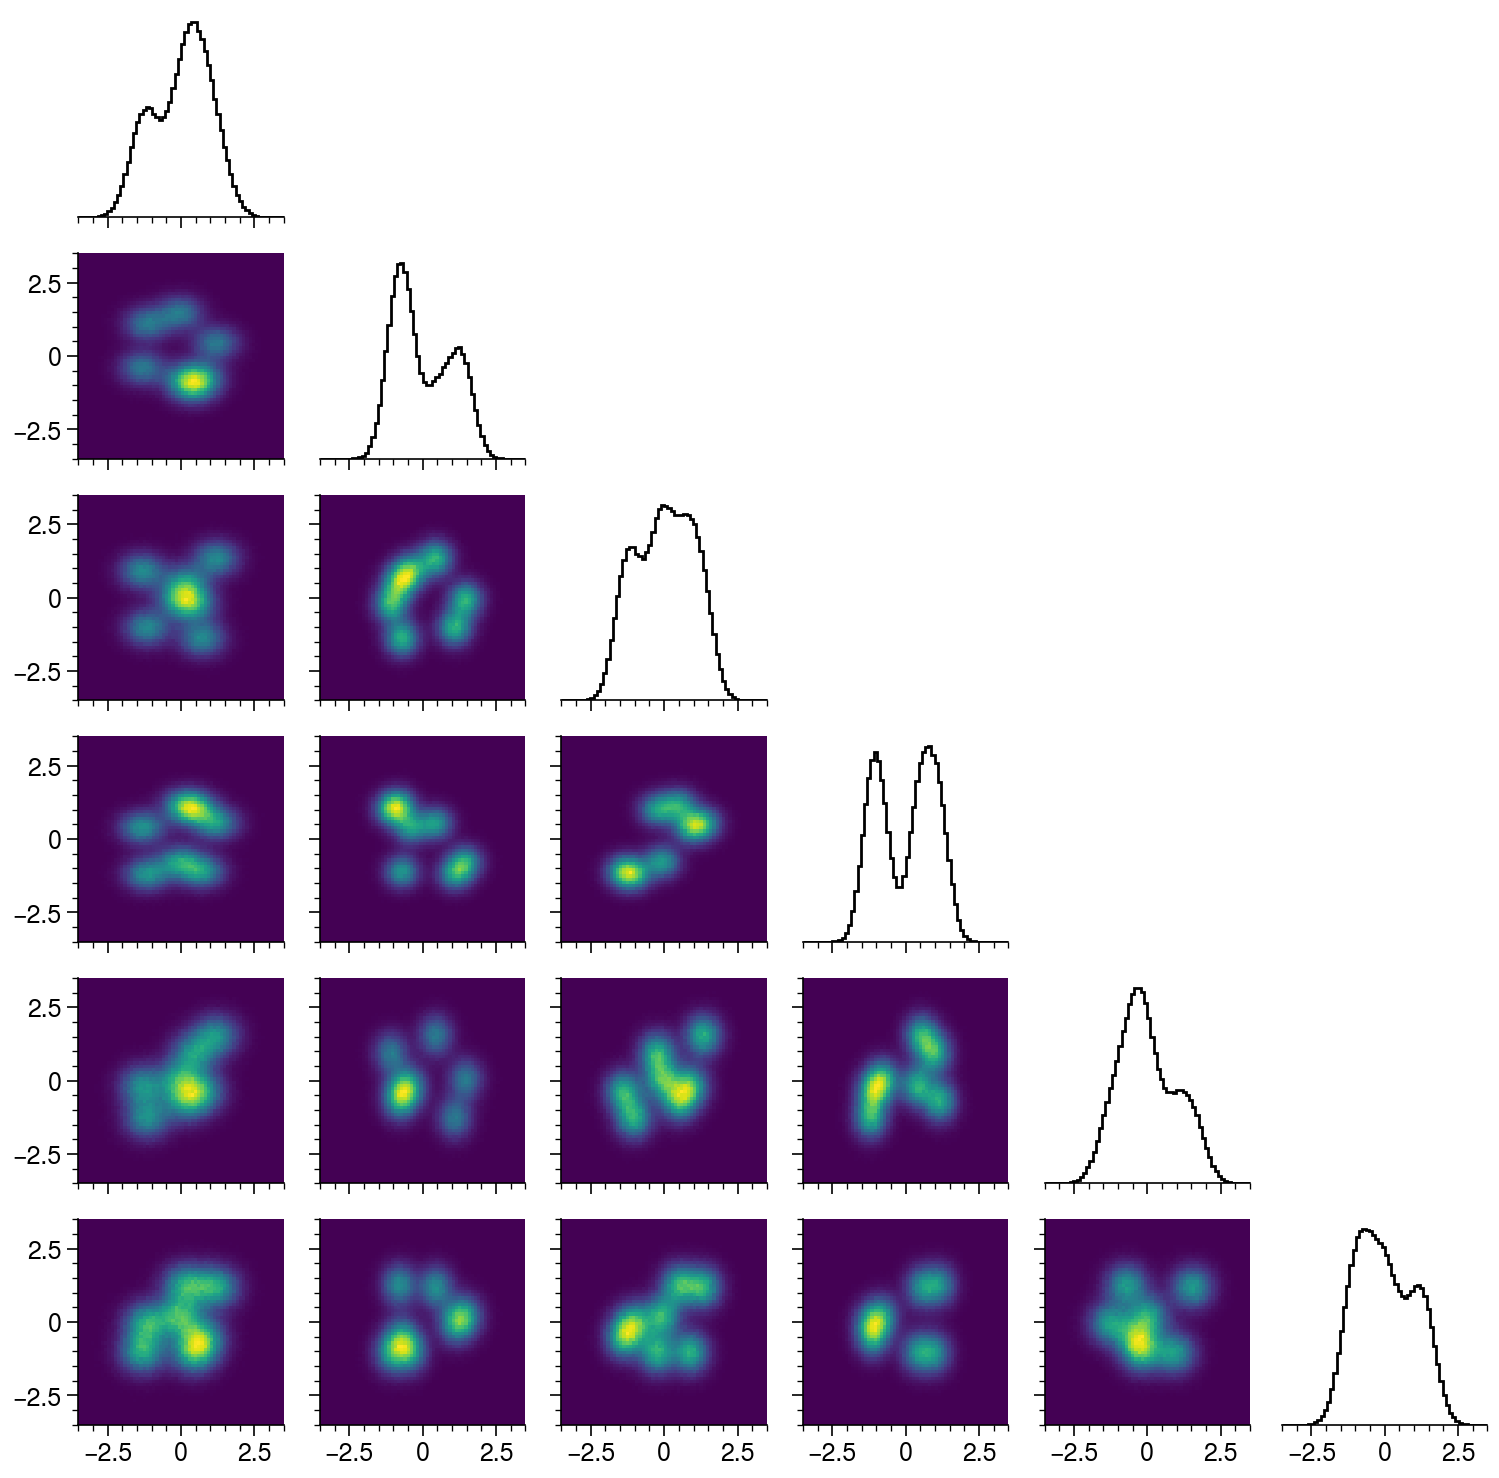

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
nmeas = 10
nbins = 64
blur = 0.0
kde = False
kde_bandwidth_frac = 1.0

Create phase space transformations.

In [7]:
class ProjectionTransform:
    def __init__(self, direction: np.ndarray) -> None:
        self.direction = direction

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return np.sum(x * self.direction, axis=1)[:, None]

In [8]:
transforms = []
directions = np.random.normal(size=(nmeas, ndim))
for direction in directions:
    direction = np.random.normal(size=ndim)
    direction = direction / np.linalg.norm(direction)
    transform = ProjectionTransform(direction)
    transforms.append(transform)

Create histogram diagnostics.

In [9]:
axis_proj = axis_meas = 0
bin_edges = np.linspace(-xmax, xmax, nbins + 1)

diagnostics = []
for transform in transforms:
    diagnostic = ment.diag.Histogram1D(
        axis=axis_meas,
        edges=bin_edges,
        kde=kde,
        kde_bandwidth_frac=kde_bandwidth_frac,
    )
    diagnostics.append([diagnostic])

Generate data from the source distribution.

In [10]:
projections = ment.simulate_with_diag_update(
    x_true,
    transforms,
    diagnostics,
    kde=False,
    blur=False,
    thresh=5.00e-03,
)

## Reconstruction model

In [11]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

In [12]:
samp_method = "mcmc"

if samp_method == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif samp_method == "mcmc":
    samp_burnin = 500
    samp_chains = 1000
    samp_prop_cov = np.eye(ndim) * (0.5 ** 2)
    samp_start = np.random.normal(size=(samp_chains, ndim)) * 0.50
    
    sampler = ment.MetropolisHastingsSampler(
        ndim=ndim,
        chains=samp_chains,
        start=samp_start,
        proposal_cov=samp_prop_cov,
        burnin=samp_burnin,
        shuffle=True,
        verbose=False,
        debug=False,
        noise_scale=0.10,  # slight smoothing
        noise_type="gaussian",
    )

else:
    raise ValueError

In [13]:
model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=100_000,
    mode="sample",
    verbose=True,
)

In [14]:
sampler.debug = True
model.sample(1000)
sampler.debug = False

debug acceptance rate = None
debug axis=0 between-chain avg(x_chain_std) = 0.9414896800722544
debug axis=0 between-chain std(x_chain_std) = 0.0
debug axis=0 between-chain avg(x_chain_avg) = 0.005232973622135686
debug axis=0 between-chain std(x_chain_avg) = 0.0
debug axis=0 x_std = 0.9414896800722544
debug axis=0 x_avg = 0.005232973622135686
debug axis=1 between-chain avg(x_chain_std) = 0.9356576427318984
debug axis=1 between-chain std(x_chain_std) = 0.0
debug axis=1 between-chain avg(x_chain_avg) = 0.013107434876618612
debug axis=1 between-chain std(x_chain_avg) = 0.0
debug axis=1 x_std = 0.9356576427318984
debug axis=1 x_avg = 0.013107434876618612
debug axis=2 between-chain avg(x_chain_std) = 0.946808326148749
debug axis=2 between-chain std(x_chain_std) = 0.0
debug axis=2 between-chain avg(x_chain_avg) = 0.01987981044651418
debug axis=2 between-chain std(x_chain_avg) = 0.0
debug axis=2 x_std = 0.946808326148749
debug axis=2 x_avg = 0.01987981044651418
debug axis=3 between-chain avg(x_

## Training

In [15]:
plot_nsamp = x_true.shape[0]

In [16]:
plot_model = Plotter(
    n_samples=plot_nsamp,
    plot_proj=[
        PlotProj1D(log=False),
    ],
    plot_dist=[
        PlotDistCorner(
            fig_kws=dict(figwidth=(ndim * 1.25), diag_shrink=0.80),
            limits=(ndim * [(-xmax, xmax)]),
            bins=64,
        ),
    ],
)

eval_model = ment.train.Evaluator(nsamp=plot_nsamp)

non numeric history values being saved


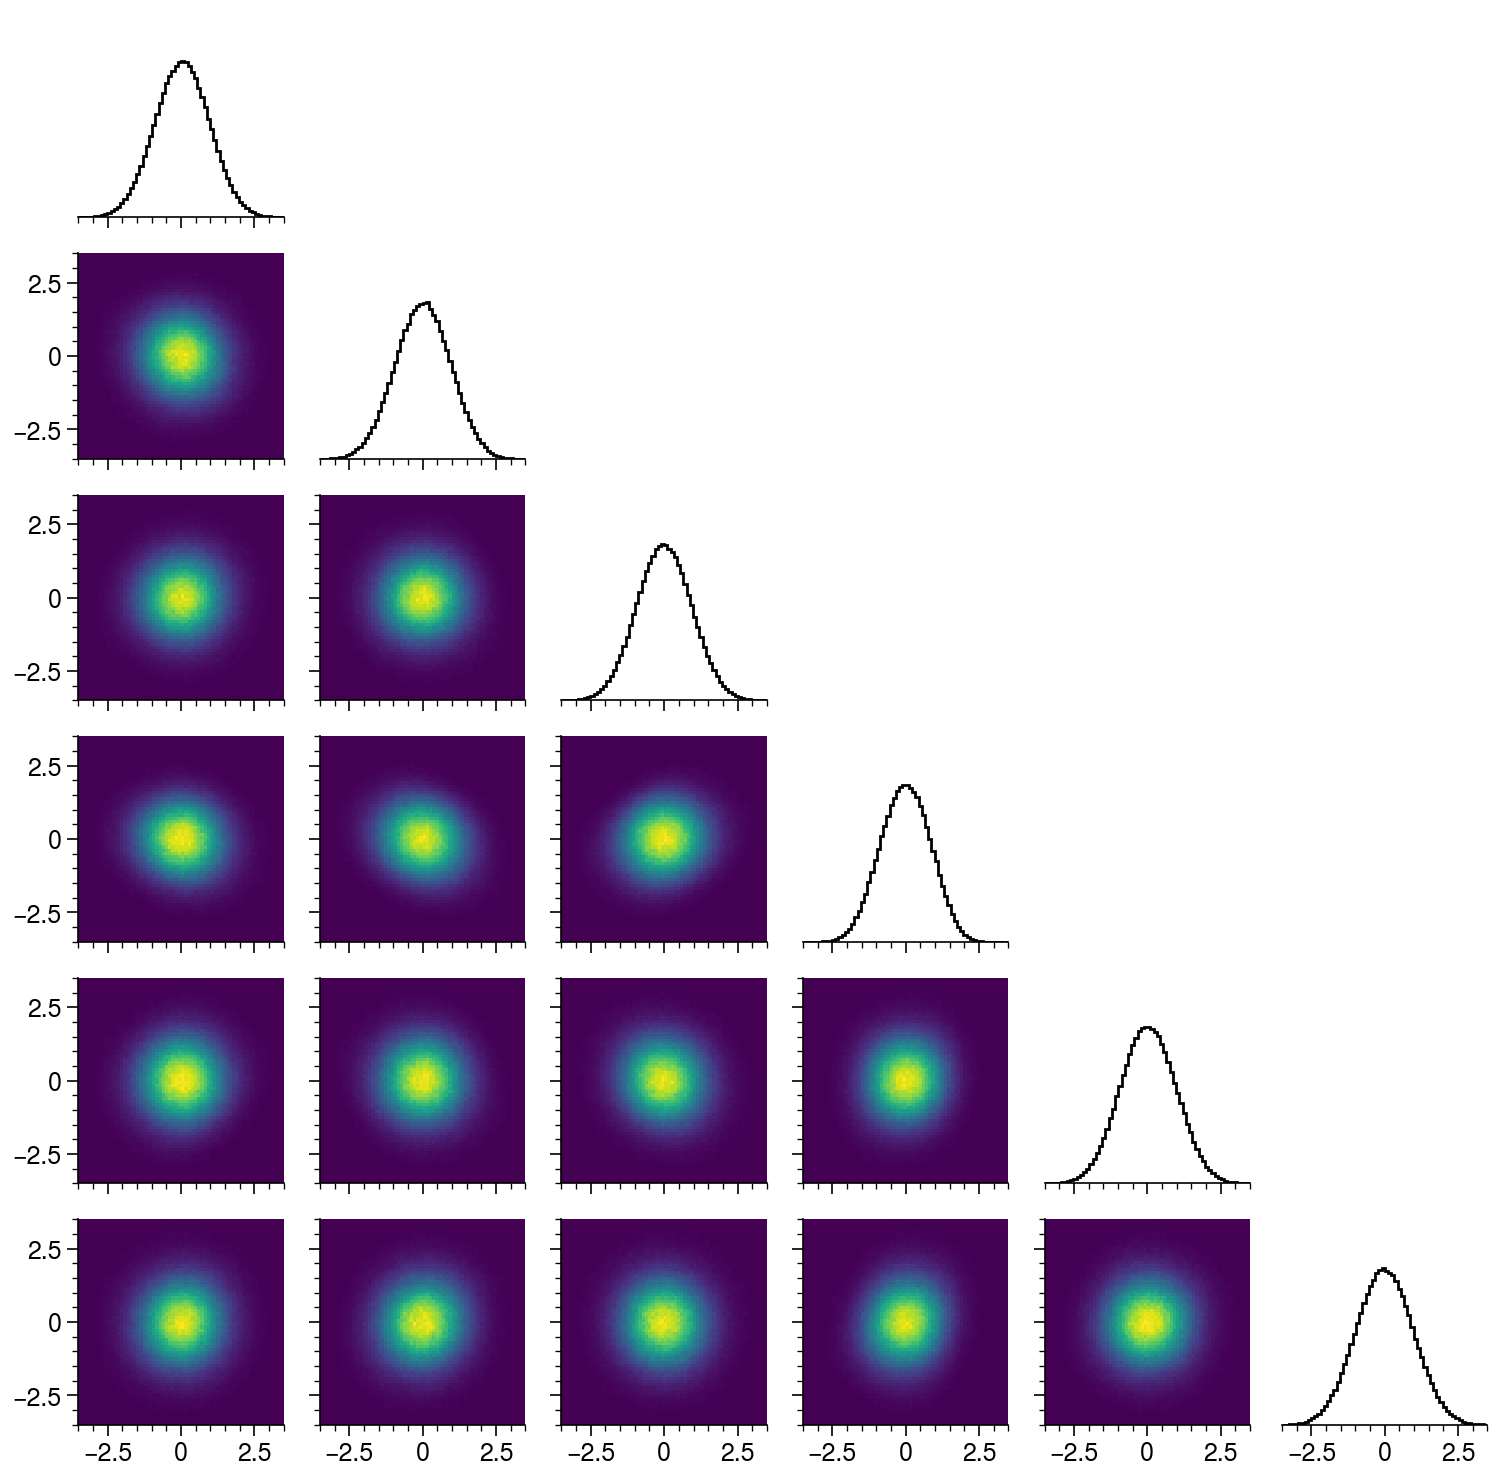

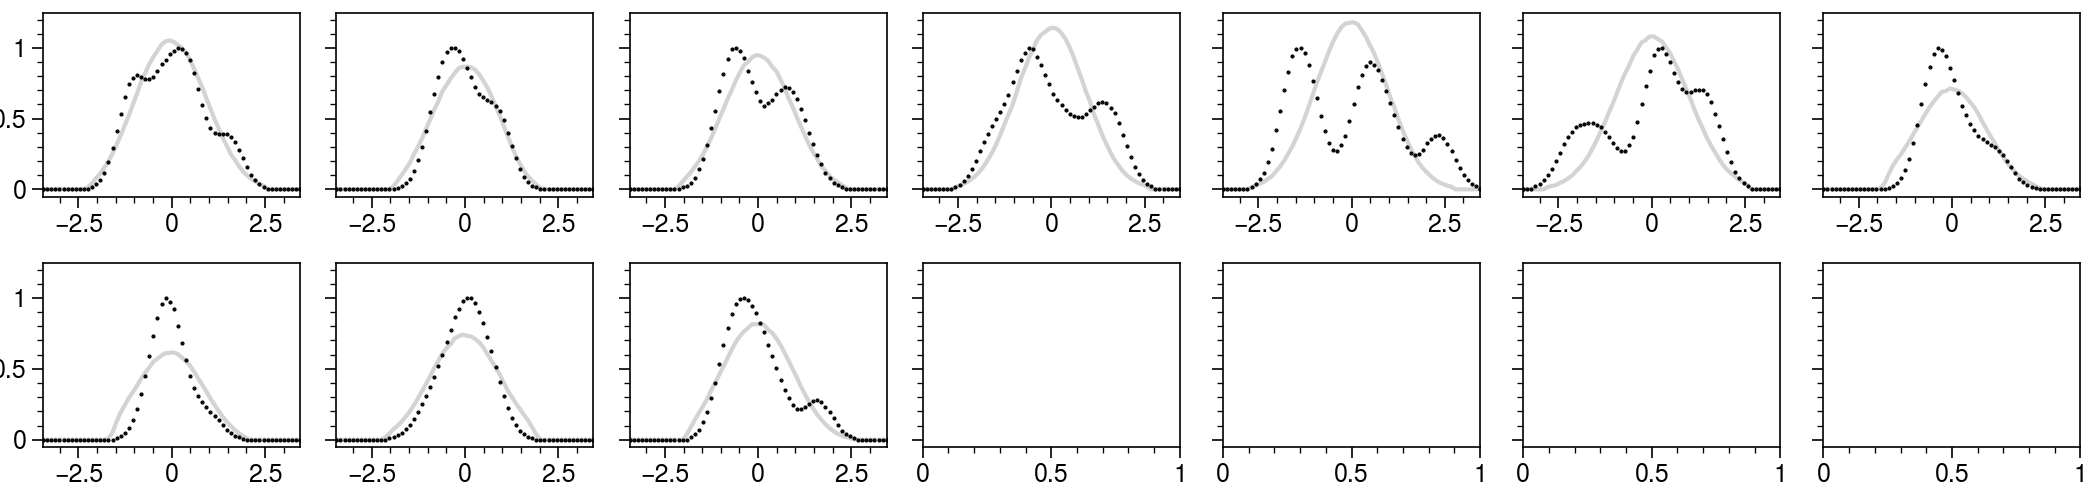

{'cov_matrix': array([[ 0.86580719, -0.04406197,  0.02762445, -0.06947751,  0.03193042,
         0.02013891],
       [-0.04406197,  0.8502851 , -0.02067551, -0.11642034, -0.02917952,
         0.05858376],
       [ 0.02762445, -0.02067551,  0.86108502,  0.09147116, -0.07256343,
        -0.01716314],
       [-0.06947751, -0.11642034,  0.09147116,  0.70720388,  0.0331342 ,
         0.07933949],
       [ 0.03193042, -0.02917952, -0.07256343,  0.0331342 ,  0.8791312 ,
         0.01601393],
       [ 0.02013891,  0.05858376, -0.01716314,  0.07933949,  0.01601393,
         0.93274414]]),
 'discrepancy': np.float64(0.04654475804202405)}
epoch = 1
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


transform=6
diagnostic=0


transform=7
diagnostic=0


transform=8
diagnostic=0


transform=9
diagnostic=0


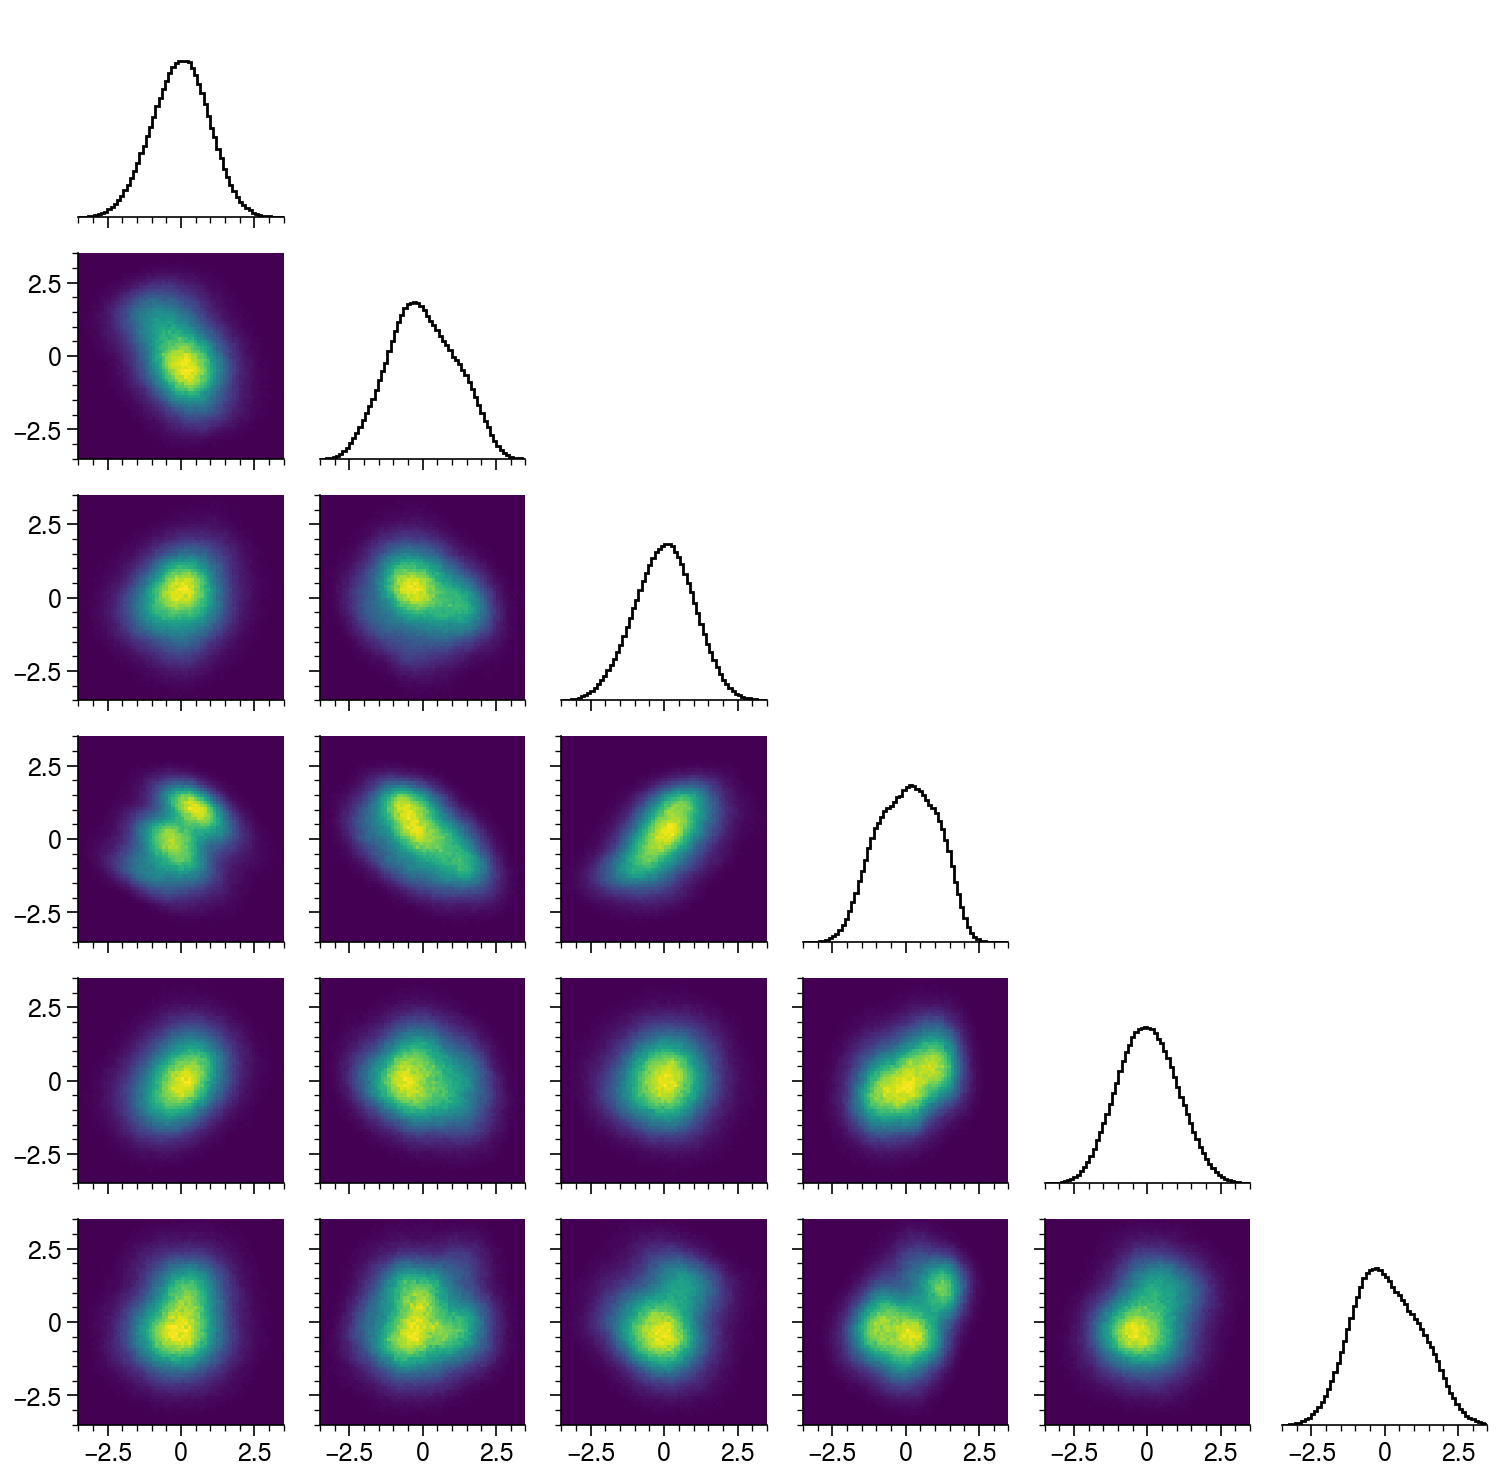

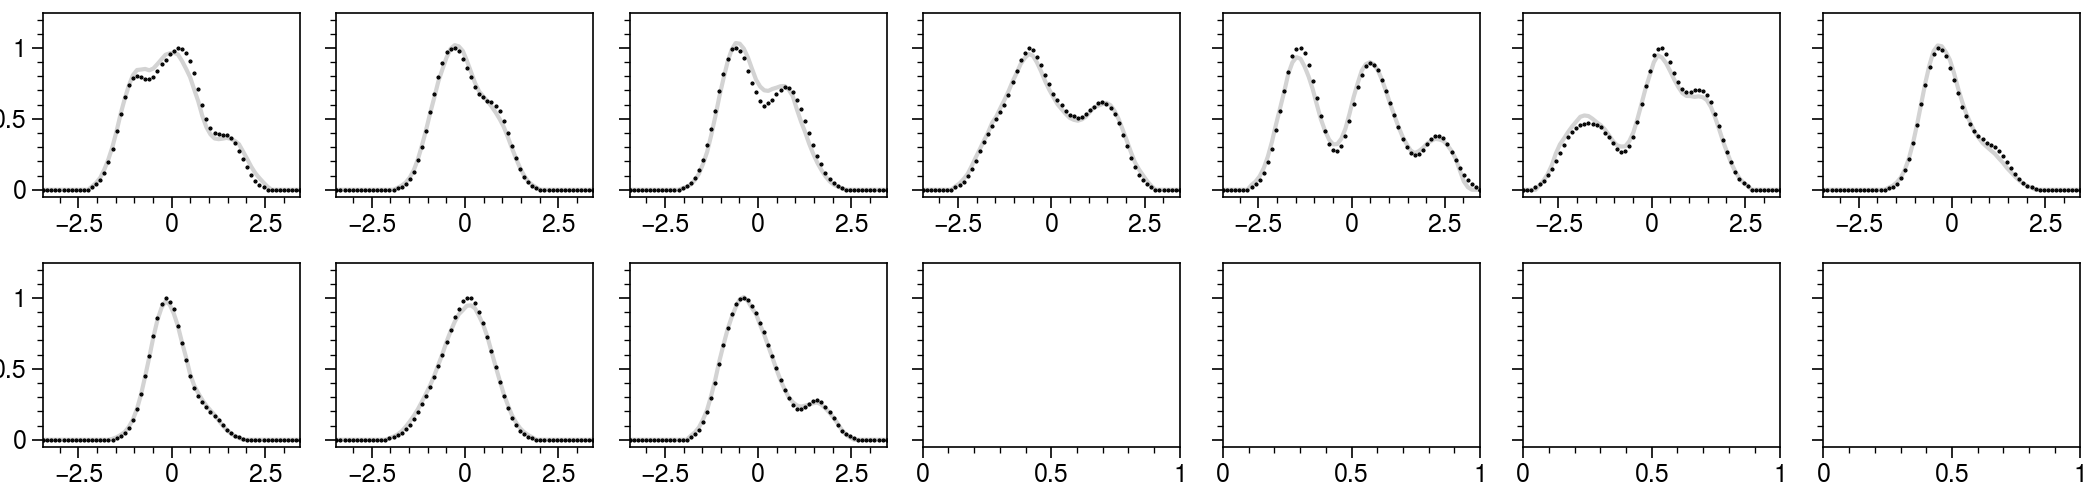

{'cov_matrix': array([[ 0.94087688, -0.38688065,  0.13612626,  0.13948621,  0.24028645,
         0.09957939],
       [-0.38688065,  1.29451781, -0.19164544, -0.52896603, -0.15822052,
         0.07077223],
       [ 0.13612626, -0.19164544,  1.03385761,  0.50896937,  0.03030645,
         0.06802124],
       [ 0.13948621, -0.52896603,  0.50896937,  1.01016347,  0.30111588,
         0.33692283],
       [ 0.24028645, -0.15822052,  0.03030645,  0.30111588,  1.00442541,
         0.19538242],
       [ 0.09957939,  0.07077223,  0.06802124,  0.33692283,  0.19538242,
         1.27530298]]),
 'discrepancy': np.float64(0.007602240760920383)}
epoch = 2
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


transform=6
diagnostic=0


transform=7
diagnostic=0


transform=8
diagnostic=0


transform=9
diagnostic=0


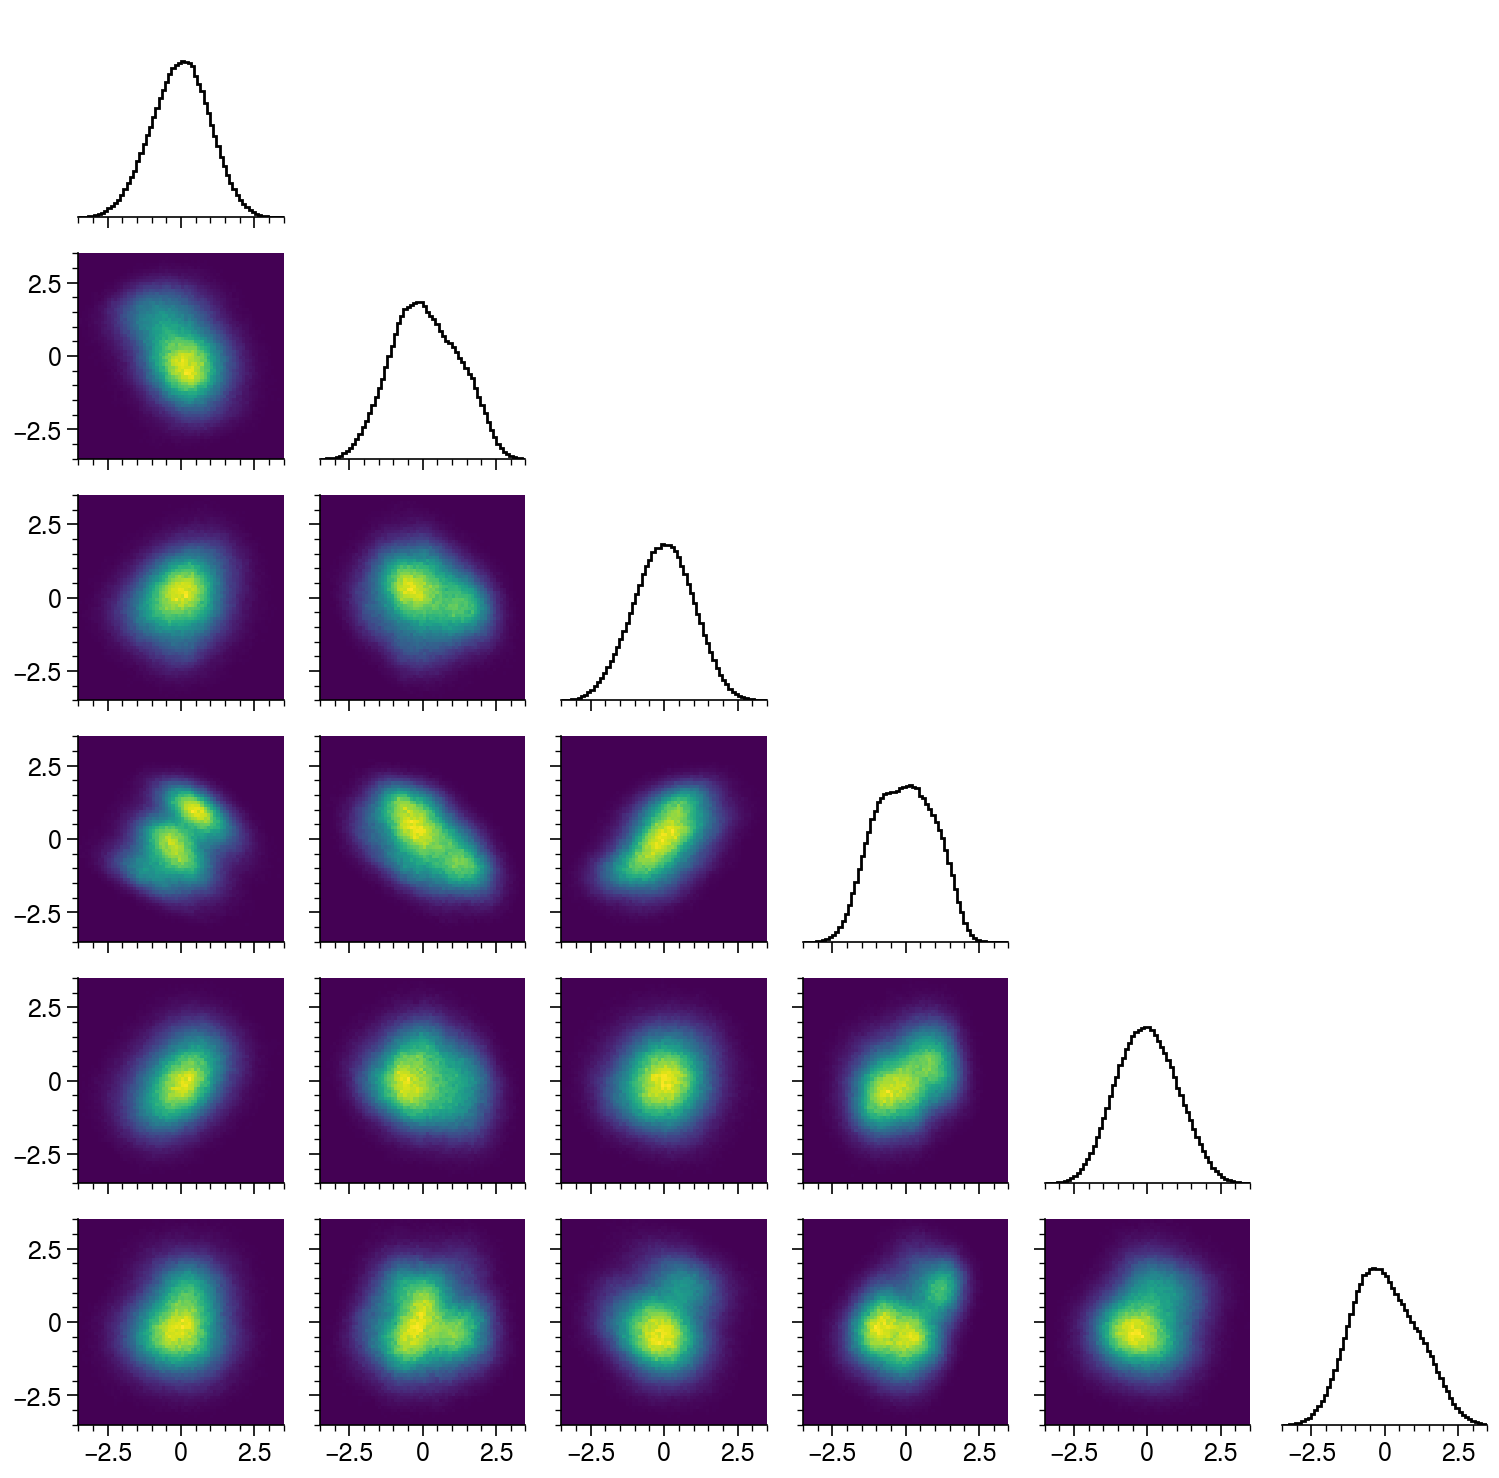

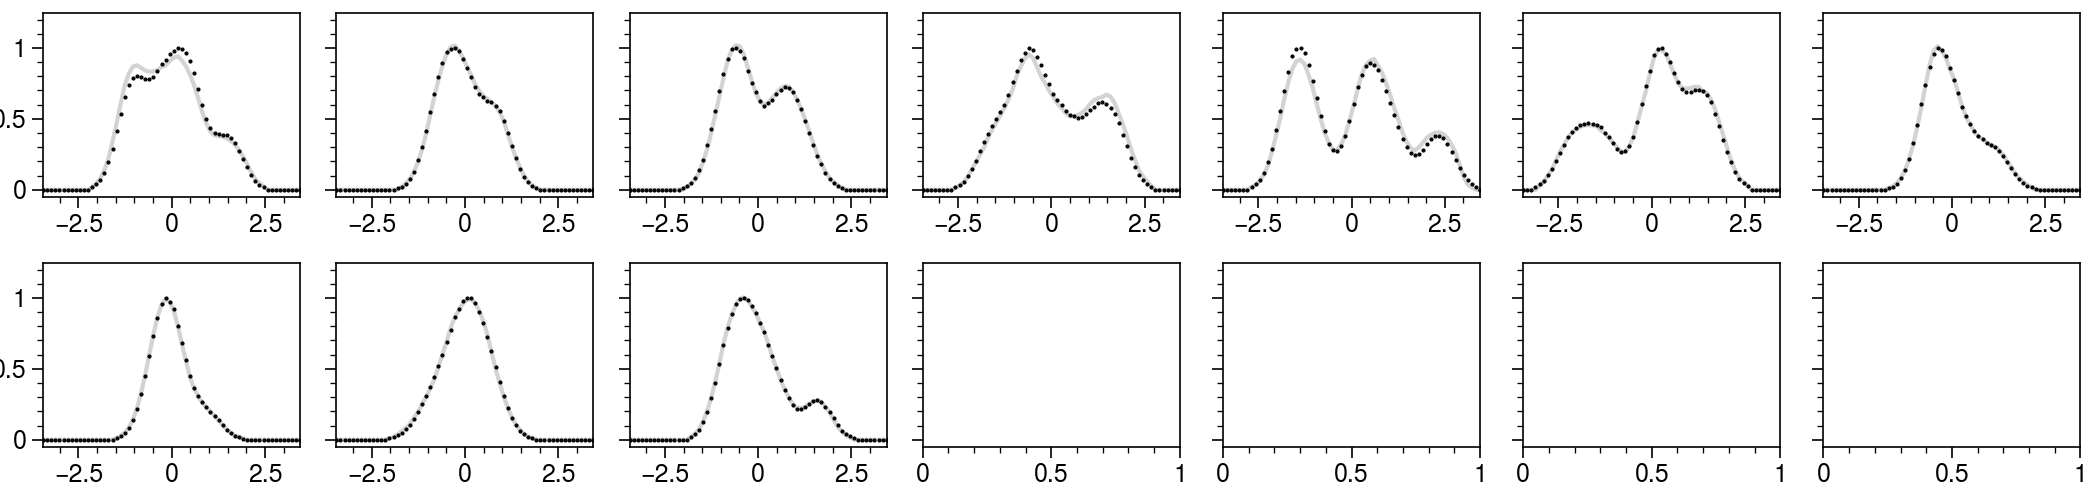

{'cov_matrix': array([[ 0.97282076, -0.36216464,  0.18468544,  0.14216181,  0.32479774,
         0.12251609],
       [-0.36216464,  1.28500378, -0.21390084, -0.56318163, -0.15149152,
         0.00569341],
       [ 0.18468544, -0.21390084,  1.04050402,  0.49496935,  0.05487983,
         0.06747649],
       [ 0.14216181, -0.56318163,  0.49496935,  1.00876129,  0.30532986,
         0.36219877],
       [ 0.32479774, -0.15149152,  0.05487983,  0.30532986,  1.0718956 ,
         0.18977717],
       [ 0.12251609,  0.00569341,  0.06747649,  0.36219877,  0.18977717,
         1.25746488]]),
 'discrepancy': np.float64(0.005842486952264586)}
epoch = 3
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


transform=6
diagnostic=0


transform=7
diagnostic=0


transform=8
diagnostic=0


transform=9
diagnostic=0


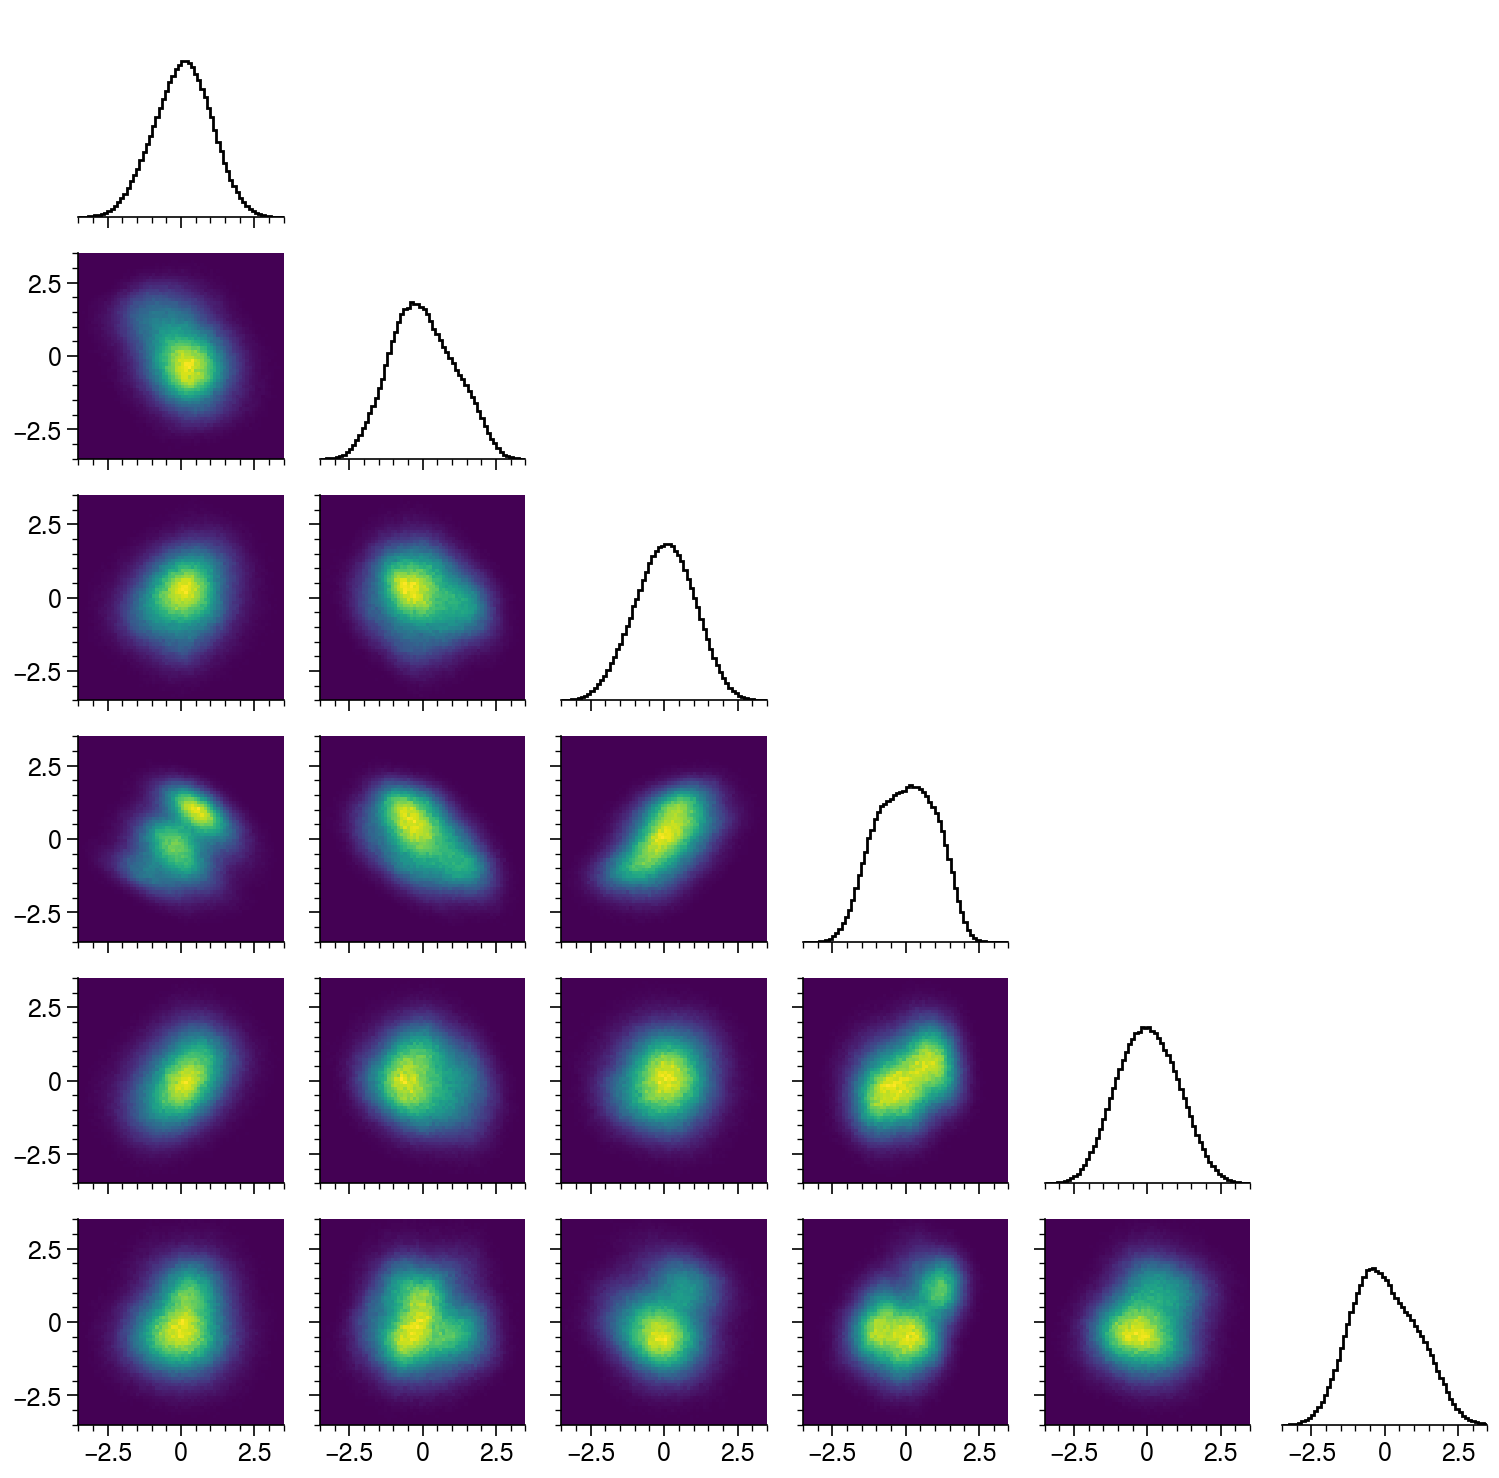

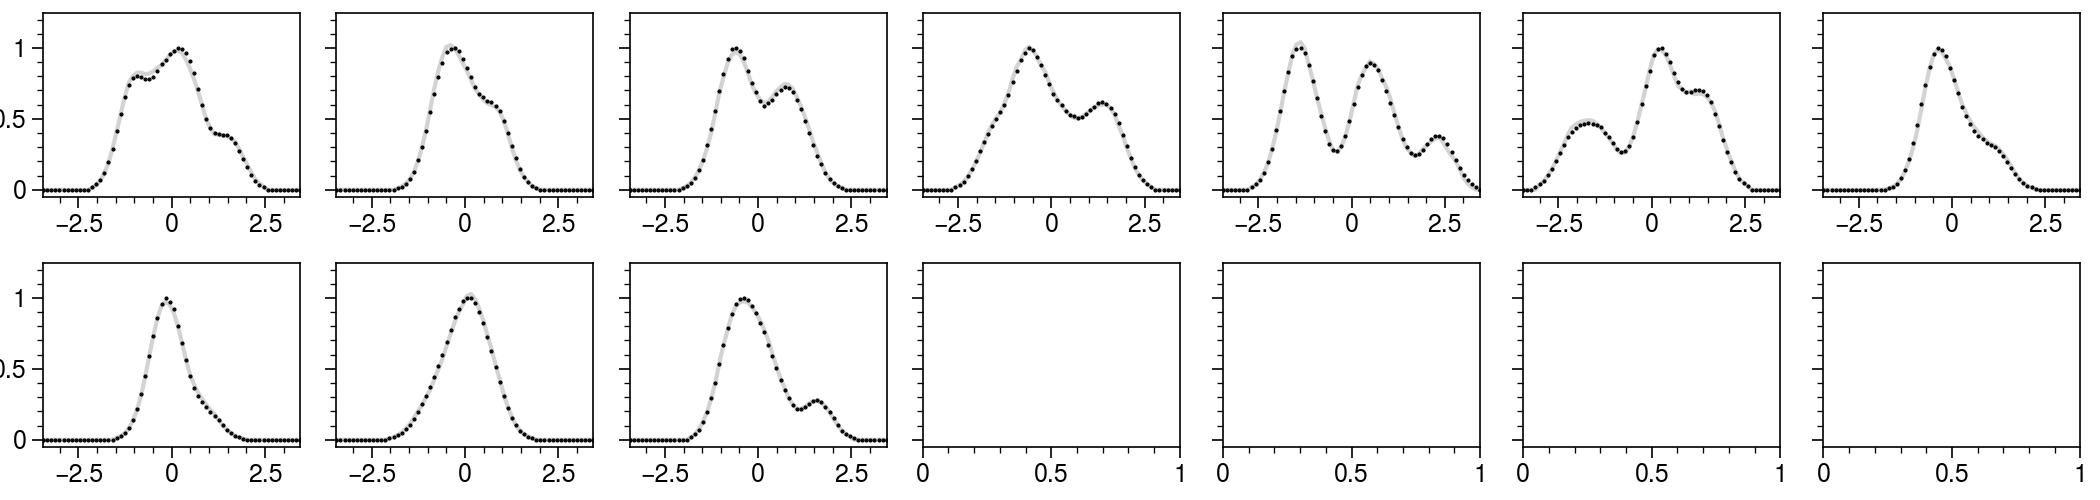

{'cov_matrix': array([[ 0.9659963 , -0.33535848,  0.18167374,  0.1305185 ,  0.32979654,
         0.12075885],
       [-0.33535848,  1.20872484, -0.19192504, -0.52828998, -0.15015222,
        -0.01738022],
       [ 0.18167374, -0.19192504,  1.04211296,  0.50202898,  0.05753679,
         0.07984211],
       [ 0.1305185 , -0.52828998,  0.50202898,  1.00626364,  0.31187073,
         0.36693433],
       [ 0.32979654, -0.15015222,  0.05753679,  0.31187073,  1.08242488,
         0.17655726],
       [ 0.12075885, -0.01738022,  0.07984211,  0.36693433,  0.17655726,
         1.2331966 ]]),
 'discrepancy': np.float64(0.003976296782770748)}


In [17]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=eval_model,
    notebook=True,
)

trainer.train(epochs=3, learning_rate=0.95)

## Evaluate

In [18]:
x_pred = model.unnormalize(model.sample(1_000_000))

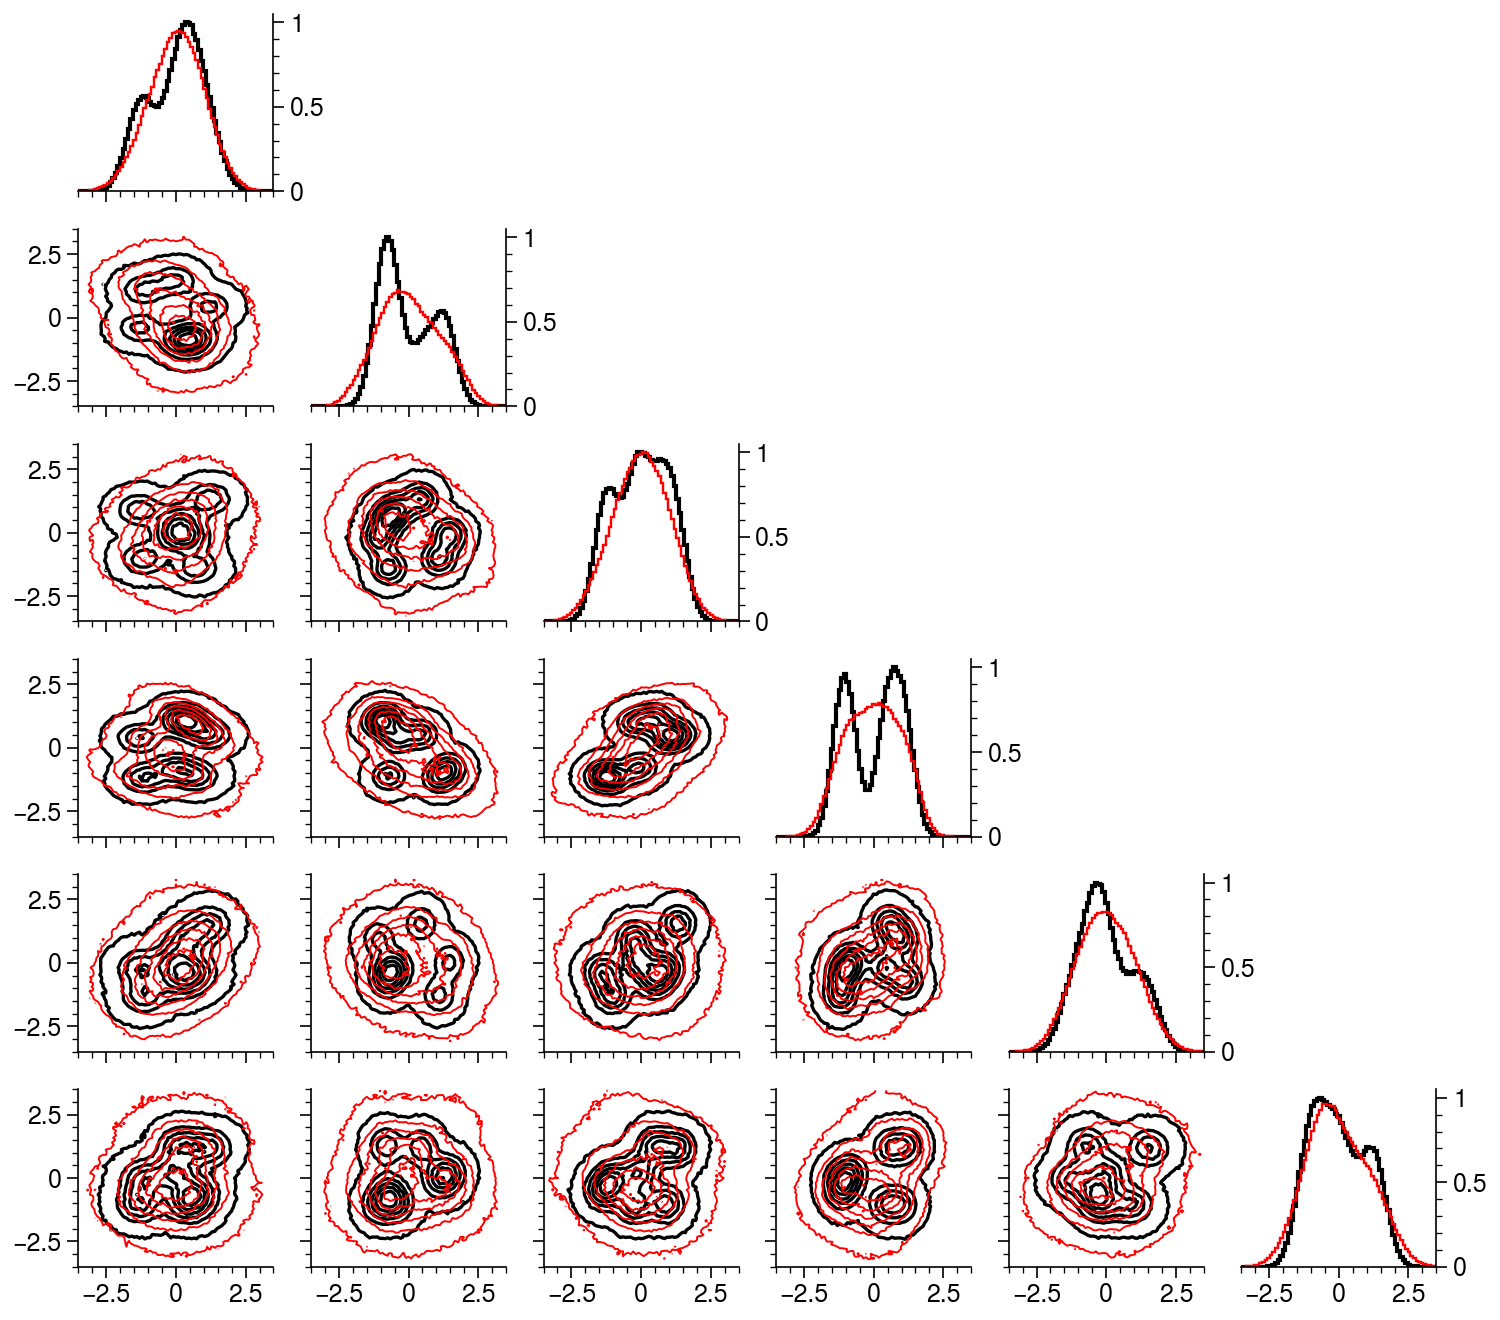

In [19]:
grid = psv.CornerGrid(ndim, figheight=(ndim * 1.10), figwidth=(ndim * 1.25), diag_rspine=True, space=1.5)
for i, x in enumerate([x_true, x_pred]):
    color = ["black", "red"][i]
    lw = [1.2, 0.7][i]
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color, lw=(lw * 1.25)),
        kind="contour",
        process_kws=dict(blur=0.0, scale="max"),
        mask=False,
        levels=np.linspace(0.01, 1.0, 7),
        color=color,
        lw=lw,
    )
plt.show()

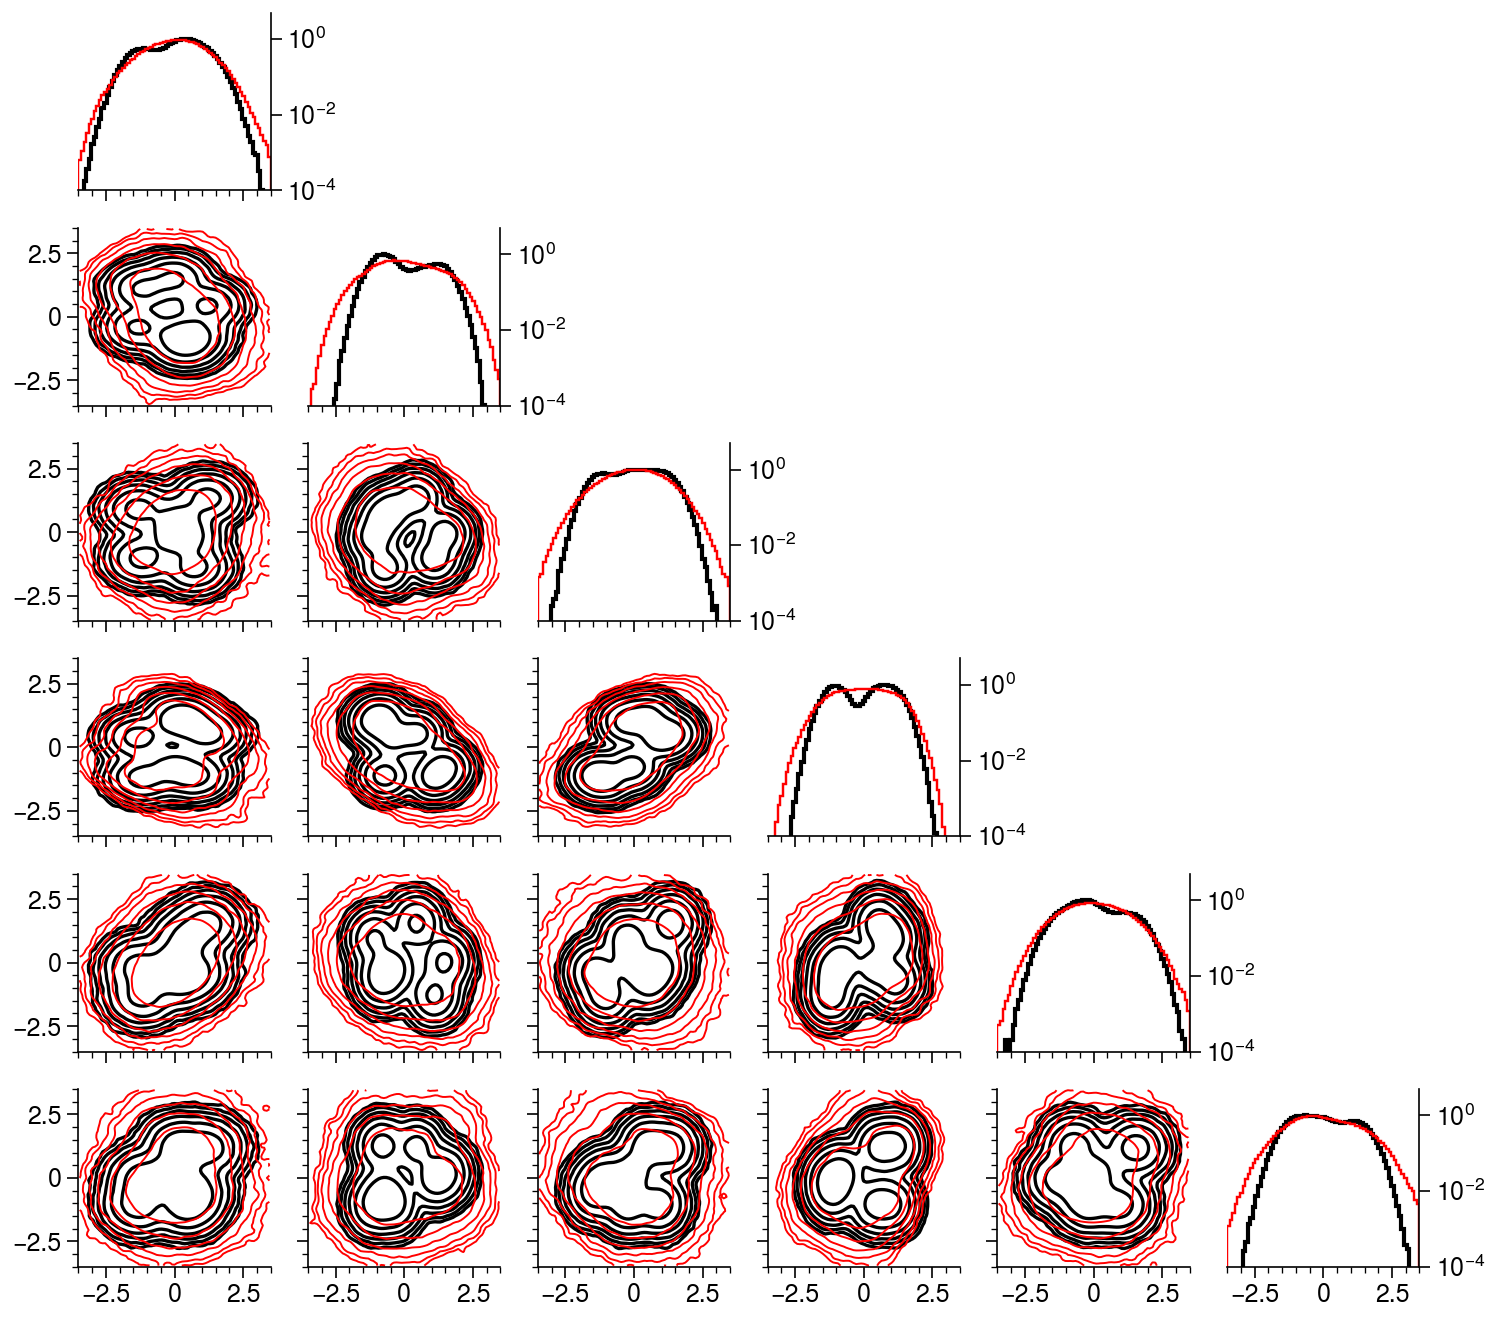

In [20]:
grid = psv.CornerGrid(ndim, figheight=(ndim * 1.10), figwidth=(ndim * 1.25), diag_rspine=True, space=1.5)
for i, x in enumerate([x_true, x_pred]):
    color = ["black", "red"][i]
    lw = [1.2, 0.7][i]
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color, lw=(lw * 1.25)),
        kind="contour",
        process_kws=dict(blur=1.0, scale="max"),
        mask=False,
        levels=(10.0 ** np.linspace(-3.0, 0.0, 7)),
        color=color,
        lw=lw,
    )
    grid.format_diag(yscale="log", yformatter="log", ymax=5.0, ymin=0.0001)
plt.show()